University of Zagreb  
Faculty of Electrical Engineering and Computing
  
## Machine Learning 1 2025/2026  
http://www.fer.unizg.hr/en/course/maclea1

------------------------------

### Fourth lab assignment: Parameter Estimation, Probabilistic Graphical Models, Clustering

*Version: 1.0
Last updated: 1 October 2021*

(c) 2015-2026 Jan Šnajder, Domagoj Alagić  

------------------------------

### Submission rules
By submitting the exercise, you confirm the following points:
1. You did not receive help from another when solving the exercise;
2. You attributed parts of the code that were taken from the Internet by referencing them in comments;
3. You did not use parts of the code from the Internet that are specific to the laboratory exercise;
4. You have not used UI-assistants for coding such as GitHub Copilot (including generative UI tools such as ChatGPT).

**Violation of any of the above rules is considered a misdemeanor and results in academic sanctions.**

### Instructions

Fourth lab assignment consists of eight tasks. Follow the instructions in the text cells below. Solving the lab assignment boils down to **supplementing this notebook**: inserting one or more cells **below** the text of the task, writing the appropriate code, and executing the cells.

Make sure you fully understand the code you've written. When submitting the assignment, you must be able to modify and re-execute your code at the request of the teaching assistant. Furthermore, you need to understand the theoretical basis of what you are doing, within the framework of what we covered in the lecture. Below some tasks you can also find questions that serve as guidelines for a better understanding of the material (**do not write** the answers to the questions in the notebook). Therefore, do not limit yourself only to solving the tasks, but feel free to experiment. This is precisely the purpose of these assignments.

You should do the assignment **independently**. You can consult others on the principle way of solving it, but ultimately you have to do the assignment yourself. Otherwise, the assignment makes no sense.

In [1]:
# Load core packages...
import sklearn
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import pgmpy as pgm
%pylab inline

def plot_silhouette(n_clusters, X):
    # Code taken from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = plt.cm.get_cmap("Dark2")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_xlabel("Values of the silhouette coefficients")
    ax1.set_ylabel("Group label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = plt.cm.get_cmap("Dark2")
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='o', s=30, lw=0, alpha=1,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers # changed to black
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="black", alpha=1, s=100, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=80, edgecolor='k')

    ax2.set_xlabel(r"$x_1$")
    ax2.set_ylabel(r"$x_2$")

    plt.show()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### 1. Maximum likelihood estimation

#### (a)

Define the likelihood function $\mathcal{L}(\mu|\mathcal{D})$ for the set $\mathcal{D}=\{x^{(i)}\}_{i=1}^N$ of Bernoulli variables. Let $m$ out of $N$ variables have the value 1 (eg, out of $N$ tossings of a coin, $m$ times we got heads). Define the likelihood function so that it is parameterized by $N$ and $m$: $\mathcal{L}(\mu|N,m)$.

In [2]:
def L(mu, N, m):
    return (mu**m) * ((1 - mu)**(N - m))

#### (b)

Plot the function $\mathcal{L}(\mu|N,m)$ for (1) $N=10$ and $m=1,2,5,9$ and for (2) $N=100$ and $ m=$1,10,50,90 (two separate graphs).

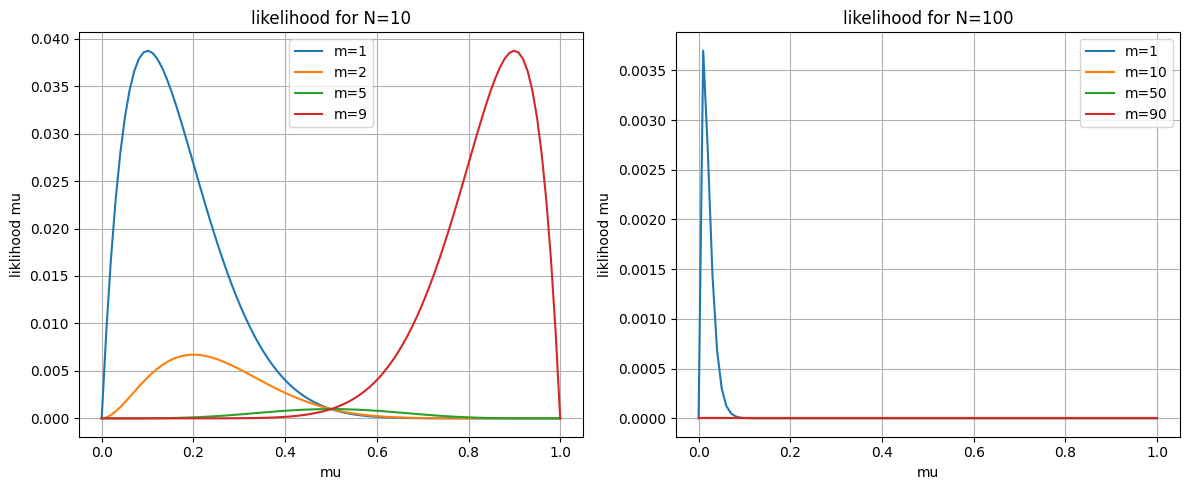

In [3]:
mu_values = np.linspace(0, 1, 100)
# 1
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for m in [1, 2, 5, 9]:
    plt.plot(mu_values, L(mu_values, 10, m), label=f'm={m}')
plt.title('likelihood for N=10')
plt.xlabel('mu')
plt.ylabel('liklihood mu')
plt.legend()
plt.grid(True)

# 2
plt.subplot(1, 2, 2)
for m in [1, 10, 50, 90]:
    plt.plot(mu_values, L(mu_values, 100, m), label=f'm={m}')
plt.title('likelihood for N=100')
plt.xlabel('mu')
plt.ylabel('liklihood mu')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Q:** Which value corresponds to the ML-estimates and why?

#### (c)

Plot the function $\mathcal{L}(\mu|N,m)$ for $N=10$ and $m=\{0,9\}$.

<Figure size 1200x500 with 0 Axes>

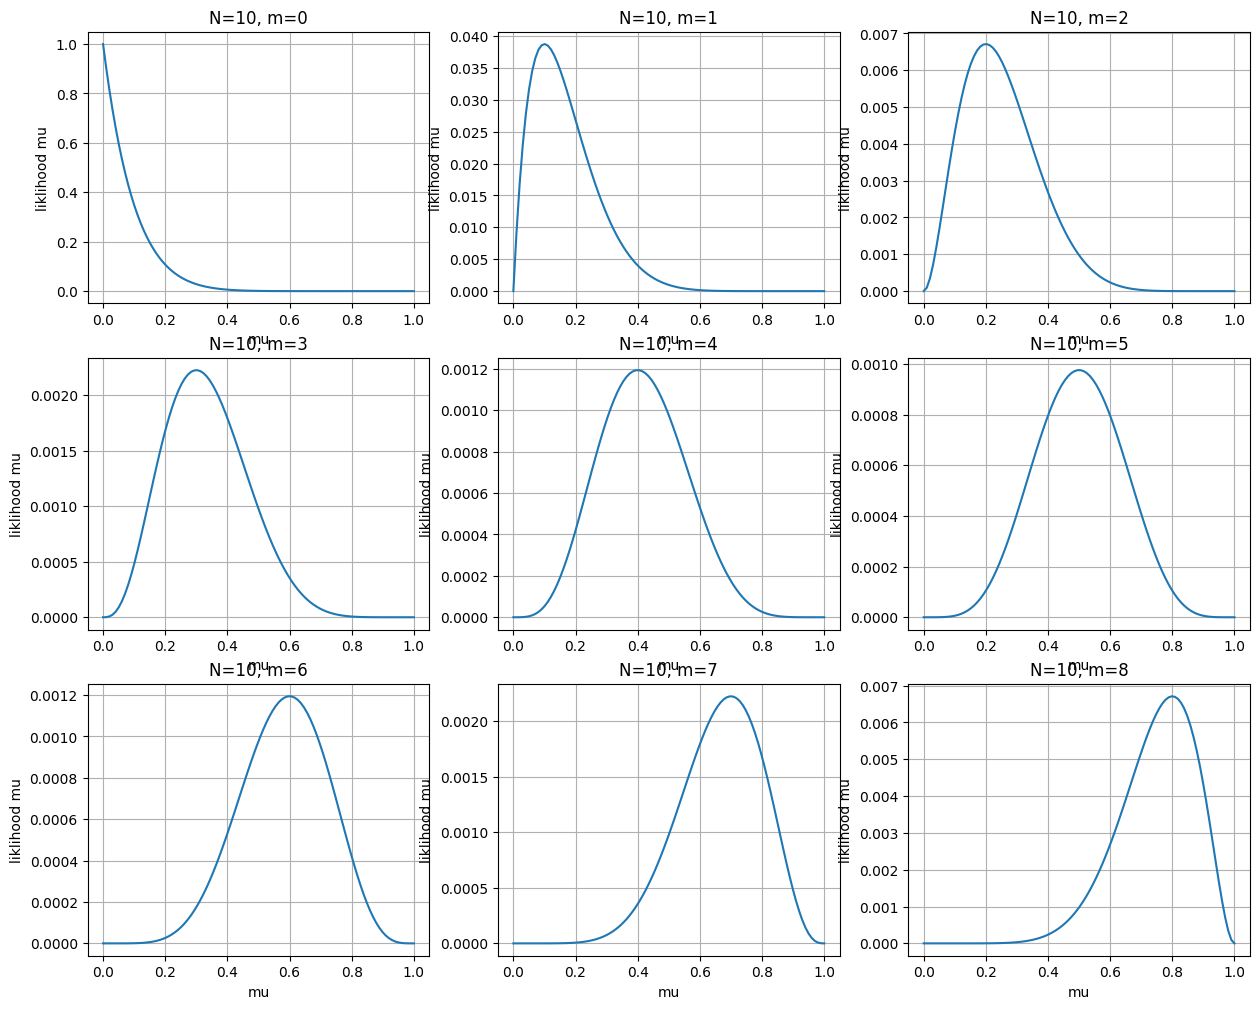

In [4]:
mu_values = np.linspace(0, 1, 100)

# N = 10
plt.figure(figsize=(12, 5))
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten() 

for i in range (0,9):
    likelihood = L(mu_values, 10, i)
    axes[i].plot(mu_values, likelihood)
    axes[i].set_title(f'N=10, m={i}')
    axes[i].set_xlabel(f'mu')
    axes[i].set_ylabel('liklihood mu')
    axes[i].grid(True)
plt.show()


**Q:** What is the ML-estimate for $\mu$ and what is the problem with such an estimate in this case?

### 2. Maximum aposteriori estimation

#### (a)

Show the beta-distribution $B(\mu|\alpha,\beta)$ for different combinations of parameters $\alpha$ and $\beta$, including $\alpha=\beta=1$ and $\alpha=\beta=2 $.

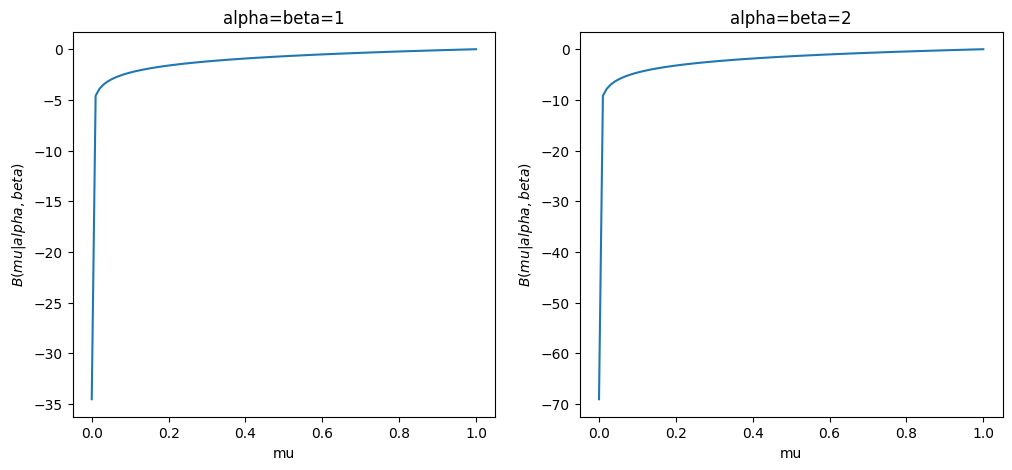

In [5]:
from scipy.stats import beta

def ln_L(mu, N, m):
    # in case log 0
    eps = 1e-15
    return m * np.log(mu + eps) + (N - m) * np.log(1 - mu + eps)


plt.figure(figsize=(12, 5))
mu_values = np.linspace(0, 1, 100)
plt.subplot(1, 2, 1)
plt.plot(mu_values, ln_L(mu_values, 1, 1), label='beta-distribution')
plt.title('alpha=beta=1')
plt.xlabel('mu')
plt.ylabel('$B(mu|alpha,beta)$')

plt.subplot(1, 2, 2)
plt.plot(mu_values, ln_L(mu_values, 2, 2), label='beta-distribution')
plt.title('alpha=beta=2')
plt.xlabel('mu')
plt.ylabel('$B(mu|alpha,beta)$')

plt.show()

**Q:** What parameters would you choose to model a priori knowledge of the parameter $\mu$ for a coin that you think is "somewhat fair, but falls on the head a bit more often"? What parameters would you choose for a coin that you think is completely fair? Why are we even using a beta distribution and not another one?

#### (b)

Define a function for calculating the joint probability $P(\mu,\mathcal{D}) = P(\mathcal{D}|\mu) \cdot P(\mu|\alpha,\beta)$ and display this function for $N=10$ and $m=9$ and several combinations of parameters $\alpha$ and $\beta$.

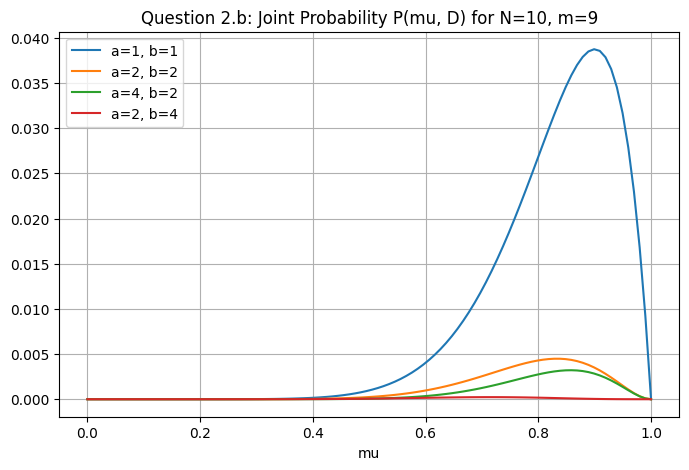

In [6]:
import math
def beta_function(a, b):
    return (math.gamma(a) * math.gamma(b)) / math.gamma(a + b)

def P_prior(mu, alpha, beta_param):
    return (mu**(alpha-1) * (1-mu)**(beta_param-1)) / beta_function(alpha, beta_param)

def P_joint(mu, N, m, alpha, beta_param):
    # Likelihood: mu^m * (1-mu)^(N-m)
    likelihood = (mu**m) * ((1 - mu)**(N - m))
    # Prior:  mu^(a-1) * (1-mu)^(b-1)
    prior = (mu**(alpha - 1)) * ((1 - mu)**(beta_param - 1))
    return likelihood * prior

mu_vals = np.linspace(0, 1, 100)
combinations = [(1,1), (2,2), (4,2), (2,4)]

plt.figure(figsize=(8, 5))
for a, b in combinations:
    plt.plot(mu_vals, P_joint(mu_vals, 10, 9, a, b), label=f'a={a}, b={b}')
plt.title('Question 2.b: Joint Probability P(mu, D) for N=10, m=9')
plt.xlabel('mu')
plt.legend()
plt.grid(True)
plt.show()



**Q**: What values correspond to the MAP-estimate for $\mu$? Compare them with the ML-estimates.

#### (c)

For $N=10$ and $m=1$, show all three distributions on one graph: $P(\mu,\mathcal{D})$, $P(\mu|\alpha,\beta)$ and $ \mathcal{L}(\mu|\mathcal{D})$.

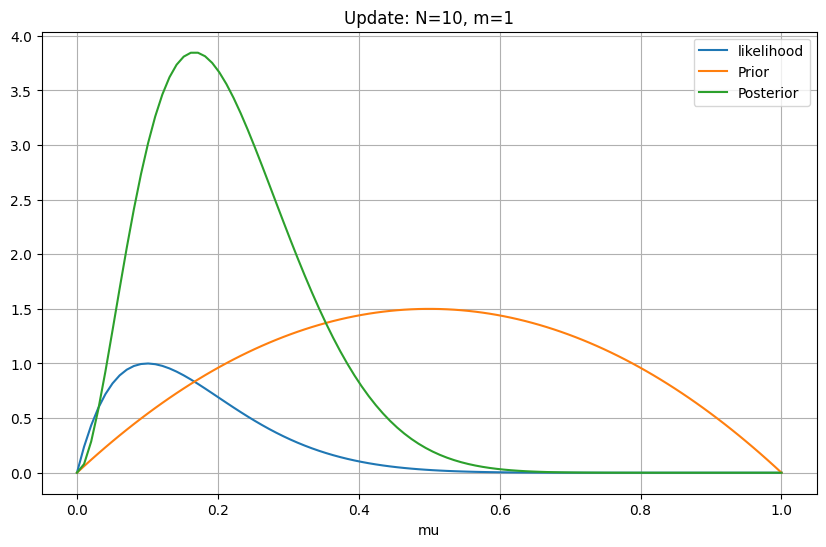

In [7]:
N = 10
m = 1
a, b = 2, 2

mu_vals = np.linspace(0, 1, 100)
likelihood = L(mu_vals, N, m)
prior = P_prior(mu_vals, a, b)
posterior = P_prior(mu_vals, a + m, b + N - m)

plt.figure(figsize=(10, 6))
plt.plot(mu_vals, likelihood / np.max(likelihood), label='likelihood')
plt.plot(mu_vals, prior, label='Prior')
plt.plot(mu_vals, posterior, label='Posterior')
plt.title(f'Update: N={N}, m={m}')
plt.xlabel('mu')
plt.legend()
plt.grid(True)
plt.show()

### 3. Analysis of the *Iris* dataset

#### (a)

Load the *Iris* dataset using the [`load_iris`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html) function. This dataset contains $n=4$ features and $K=3$ classes. Select one class and select all examples from that class, while ignoring the other examples (**in the rest of this task you will only use the examples from that one class**). Visualize the data by making 2D-plots for each pair of features (six plots; the easiest way to display them is to use the [`scatter`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter) function).

**NB:** You might find the function [`itertools.combinations`](https://docs.python.org/2/library/itertools.html#itertools.combinations) useful for this.

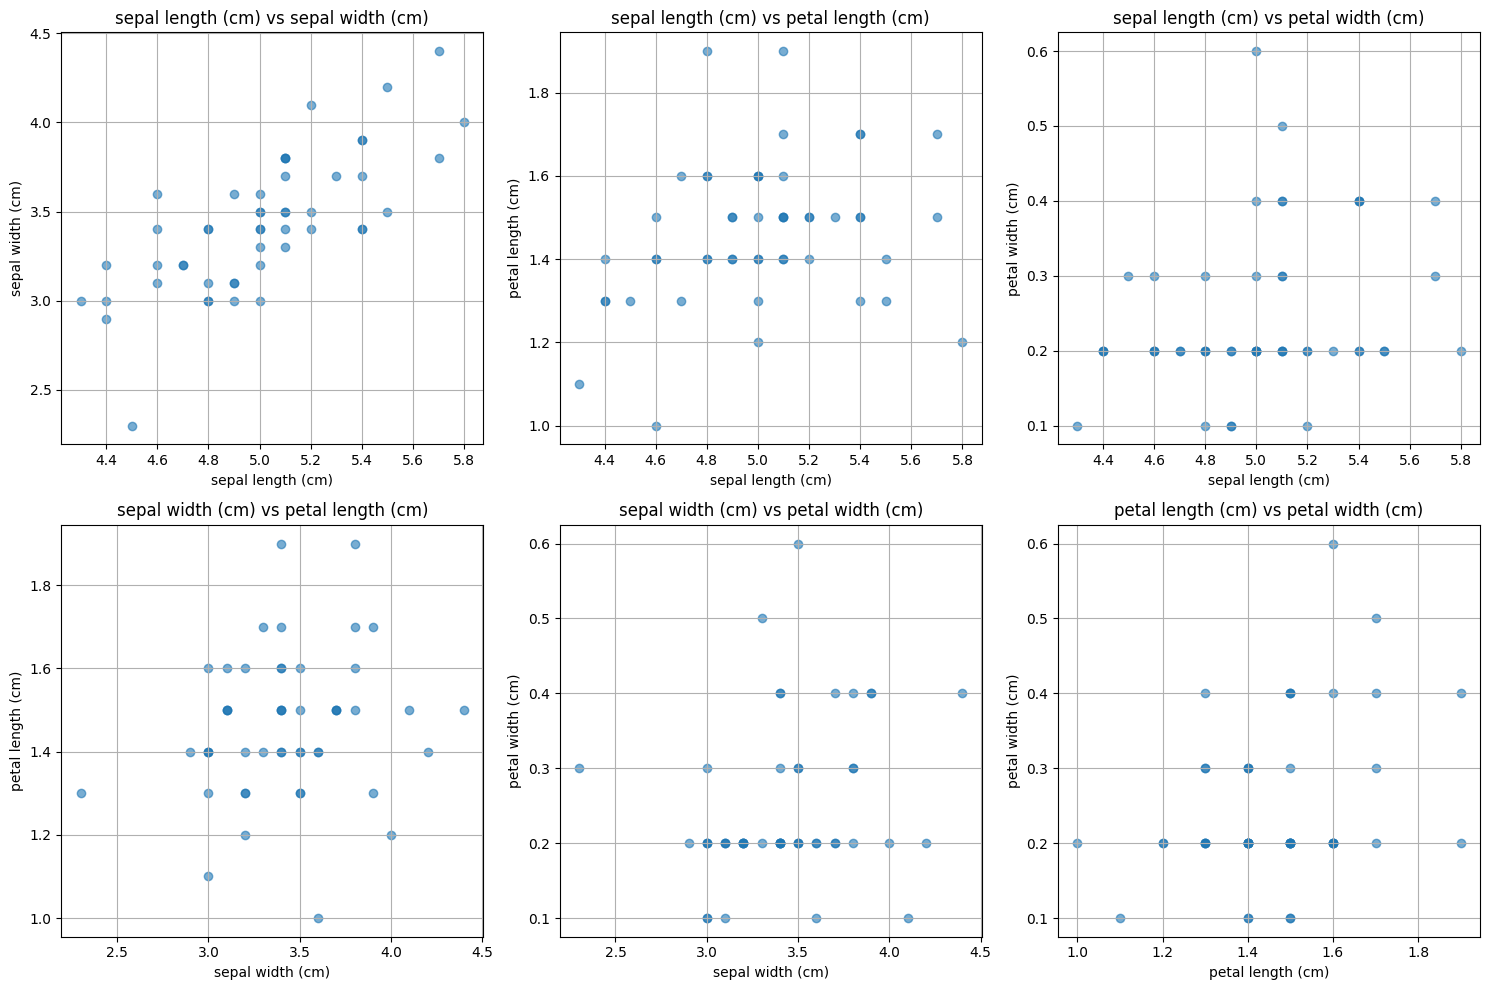

In [8]:
from sklearn.datasets import load_iris
import itertools as it

iris = load_iris()
X = iris.data
y = iris.target
#select a class
selected_class = 0
X_selected = X[y == selected_class]

# scatter plot
feature_pairs = list(it.combinations(range(4), 2))
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

#iterate over tuples
for idx, (i, j) in enumerate(feature_pairs):
    axes[idx].scatter(X_selected[:, i], X_selected[:, j], alpha=0.6)
    axes[idx].set_xlabel(iris.feature_names[i])
    axes[idx].set_ylabel(iris.feature_names[j])
    axes[idx].set_title(f'{iris.feature_names[i]} vs {iris.feature_names[j]}')
    axes[idx].grid(True)

plt.tight_layout()
plt.show()

#### (b)

Go through the description of the module [`stats`](http://docs.scipy.org/doc/scipy-0.14.0/reference/stats.html) and study the function [`norm`](http://docs.scipy. org/doc/scipy-0.14.0/reference/generated/scipy.stats.norm.html#scipy.stats.norm). Implement the log-likelihood function for the parameters $\mu$ and $\sigma^2$ of the normal distribution.

In [9]:
from scipy.stats import norm
import numpy as np

def L_gauss(x, mu, sigma):
    n = len(x)
    log_likelihood = np.sum(norm.logpdf(x, loc=mu, scale=sigma))
    return log_likelihood

x_test = np.random.normal(5, 2, 100)
print(f"log likelihood: {L_gauss(x_test, 5, 2)}")

log likelihood: -202.25505641103183


#### (c)

Compute the ML-estimates of $(\mu, \sigma^2)$ for each of the $n=4$ features from the *Iris* set. Print the log-likelihoods of those ML-estimates.

In [10]:
n_features = X.shape[1]
ml_estimates = []

for feature_idx in range(n_features):
    feature_data = X_selected[:, feature_idx]
    
    # ML estimates for normal distribution
    mu_ml = np.mean(feature_data)
    sigma_ml = np.std(feature_data, ddof=0)  # ddof=0 for ML estimate
    
    # Calculate log-likelihood
    log_lik = L_gauss(feature_data, mu_ml, sigma_ml)
    
    ml_estimates.append({
        'feature': iris.feature_names[feature_idx],
        'mu': mu_ml,
        'sigma': sigma_ml,
        'log_likelihood': log_lik
    })
    
    print(f"\nFeature: {iris.feature_names[feature_idx]}")
    print(f"  μ (ML estimate): {mu_ml:.4f}")
    print(f"  σ (ML estimate): {sigma_ml:.4f}")
    print(f"  Log-likelihood: {log_lik:.4f}")


Feature: sepal length (cm)
  μ (ML estimate): 5.0060
  σ (ML estimate): 0.3489
  Log-likelihood: -18.3052

Feature: sepal width (cm)
  μ (ML estimate): 3.4280
  σ (ML estimate): 0.3753
  Log-likelihood: -21.9394

Feature: petal length (cm)
  μ (ML estimate): 1.4620
  σ (ML estimate): 0.1719
  Log-likelihood: 17.0898

Feature: petal width (cm)
  μ (ML estimate): 0.2460
  σ (ML estimate): 0.1043
  Log-likelihood: 42.0646


#### (d)

Study the [`pearsonr`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) function to calculate the Pearson correlation coefficient. Calculate the correlation coefficients between all four features in the *Iris* set.


Correlation Matrix:
Features: ['sepal leng', 'sepal widt', 'petal leng', 'petal widt']
[[ 1.         -0.11756978  0.87175378  0.81794113]
 [-0.11756978  1.         -0.4284401  -0.36612593]
 [ 0.87175378 -0.4284401   1.          0.96286543]
 [ 0.81794113 -0.36612593  0.96286543  1.        ]]


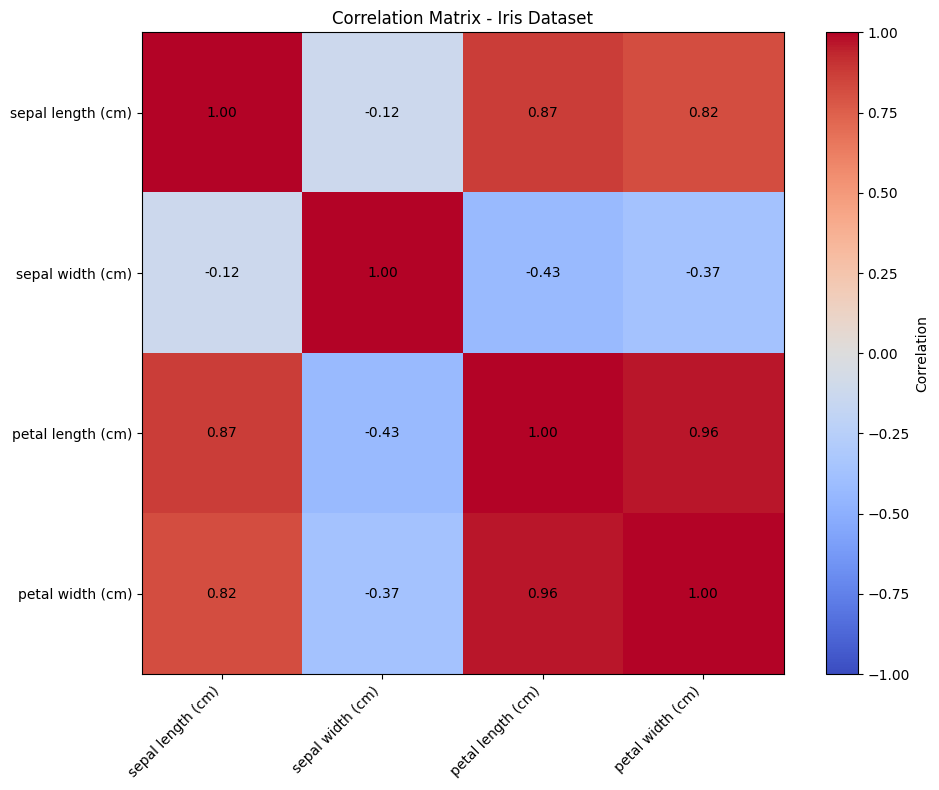

In [11]:
from scipy.stats import pearsonr

correlation_matrix = np.zeros((n_features, n_features))

for i in range(n_features):
    for j in range(n_features):
        if i == j:
            correlation_matrix[i, j] = 1.0
        else:
            corr, p_value = pearsonr(X[:, i], X[:, j])
            correlation_matrix[i, j] = corr

print("\nCorrelation Matrix:")
print("Features:", [name[:10] for name in iris.feature_names])
print(correlation_matrix)

plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.xticks(range(n_features), iris.feature_names, rotation=45, ha='right')
plt.yticks(range(n_features), iris.feature_names)
plt.title('Correlation Matrix - Iris Dataset')
for i in range(n_features):
    for j in range(n_features):
        plt.text(j, i, f'{correlation_matrix[i, j]:.2f}', 
                ha='center', va='center', color='black')
plt.tight_layout()
plt.show()

#### (e)

Study the function [`cov`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html) and calculate the ML-estimate for the covariance matrix for the *Iris* set. Compare the biased and unbiased estimation. Show that the difference (mean absolute and squared) decreases with the number of examples (eg, try for $N/4$ and $N/2$ and $N$ examples).

In [12]:
for N in [4, 2, 10, 50]:
    print(f"\nSample size N = {N}")
    # n random examples 
    indices = np.random.choice(X.shape[0], size=N, replace=False)
    X_sample = X[indices]
    # biased estimate
    cov_biased = np.cov(X_sample.T, ddof=0)
    # Unbiased estimate 
    cov_unbiased = np.cov(X_sample.T, ddof=1)
    
    diff = np.abs(cov_biased - cov_unbiased)**2
    mean_diff = np.mean(diff)
    
    print(f"  Biased estimate : {np.diag(cov_biased)}")
    print(f"  Unbiased estimate : {np.diag(cov_unbiased)}")
    print(f"  Mean squared difference: {mean_diff:.6f}")



Sample size N = 4
  Biased estimate : [1.716875 0.1275   4.986875 0.6725  ]
  Unbiased estimate : [2.28916667 0.17       6.64916667 0.89666667]
  Mean squared difference: 0.360893

Sample size N = 2
  Biased estimate : [2.7225 0.09   7.84   1.1025]
  Unbiased estimate : [ 5.445  0.18  15.68   2.205]
  Mean squared difference: 8.636252

Sample size N = 10
  Biased estimate : [0.9016 0.2461 2.444  0.4029]
  Unbiased estimate : [1.00177778 0.27344444 2.71555556 0.44766667]
  Mean squared difference: 0.010149

Sample size N = 50
  Biased estimate : [0.7109   0.215024 3.126256 0.593844]
  Unbiased estimate : [0.72540816 0.21941224 3.19005714 0.60596327]
  Mean squared difference: 0.000467


### 4. Probabilistic graphical models -- Bayesian networks

This task will deal with Bayesian networks, one of the most known probabilistic graphical models (PGM). For easier experimentation, we will use the package [`pgmpy`](https://github.com/pgmpy/pgmpy). Please check if you have this package installed and install it if you don't. Instructions are at the link above. For Anaconda users, it's the easiest to type `conda install -c ankurankan pgmpy` (or `pip install pgmpy` if it doesn't work) inside the Anaconda Prompt (and restart Jupyter).

First, we'll look at a textbook example with a sprinkler. In this example, we consider a Bayesian network that models dependencies between cloud (random variable $C$), rain ($R$), sprinkler ($S$), and wet grass ($W$). In this example, we also assume that we already have the parameters of the probability distributions of all nodes. The network is shown in the following picture:

![This](http://www.fer.unizg.hr/_download/repository/bayes-net-sprinkler.jpg)

Using the `pgmpy` package, construct the Bayesian network from the example above. Then, using **exact** inference, set the following posterior queries: $P(w=1)$, $P(s=1|w=1)$, $P(r=1|w=1)$, $P(c=1|s=1, r=1)$ and $P(c=1)$. Do the reasoning on paper and make sure you constructed the network correctly. The official documentation and usage examples will help you (eg [this](https://github.com/pgmpy/pgmpy/blob/dev/examples/Monty%20Hall%20Problem.ipynb)).

In [17]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.inference import VariableElimination

In [ ]:
model = DiscreteBayesianNetwork([
    ('Cloudy', 'Sprinkler'),
    ('Cloudy', 'Rain'),
    ('Sprinkler', 'WetGrass'),
    ('Rain', 'WetGrass')
])

# P(cloudy)
cpd_cloudy = TabularCPD(
    variable='Cloudy',
    variable_card=2,
    values=[[0.5],  # P(C=T)
            [0.5]]  # P(C=F)
)
# P(sprinkler | cloudy)
cpd_sprinkler = TabularCPD(
    variable='Sprinkler',
    variable_card=2,
    values=[[0.1, 0.5],  # P(S=T | C=T), P(S=T | C=F)
            [0.9, 0.5]], # P(S=F | C=T), P(S=F | C=F)
    evidence=['Cloudy'],
    evidence_card=[2]
)
# P(rain | cloudy)
cpd_rain = TabularCPD(
    variable='Rain',
    variable_card=2,
    values=[[0.8, 0.2],  # P(R=T | C=T), P(R=T | C=F)
            [0.2, 0.8]], # P(R=F | C=T), P(R=F | C=F)
    evidence=['Cloudy'],
    evidence_card=[2]
)
# P(wetGrass | sprinkler, rain)
cpd_wetgrass = TabularCPD(
    variable='WetGrass',
    variable_card=2,
    values=[[0.99, 0.90, 0.90, 0.00],  # P(W=T | S, R)
            [0.01, 0.10, 0.10, 1.00]], # P(W=F | S, R)
    evidence=['Sprinkler', 'Rain'],
    evidence_card=[2, 2]
)
model.add_cpds(cpd_cloudy, cpd_sprinkler, cpd_rain, cpd_wetgrass)
print(model.check_model())
inference = VariableElimination(model)
queries = [
    {'variables': ['WetGrass'], 'evidence': {}},
    {'variables': ['Sprinkler'], 'evidence': {'WetGrass': 1}},
    {'variables': ['Rain'], 'evidence': {'WetGrass': 1}},
    {'variables': ['Cloudy'], 'evidence': {'Sprinkler': 1, 'Rain': 1}},
    {'variables': ['Cloudy'], 'evidence': {}}
]
for i, query in enumerate(queries, 1):
    result = inference.query(variables=query['variables'], evidence=query['evidence'])
    print(f"\nQuery {i}: P({query['variables'][0]},  {query['evidence']})")
    print(result)

True

Query 1: P(WetGrass,  {})
+-------------+-----------------+
| WetGrass    |   phi(WetGrass) |
+=============+=================+
| WetGrass(0) |          0.6471 |
+-------------+-----------------+
| WetGrass(1) |          0.3529 |
+-------------+-----------------+

Query 2: P(Sprinkler,  {'WetGrass': 1})
+--------------+------------------+
| Sprinkler    |   phi(Sprinkler) |
+==============+==================+
| Sprinkler(0) |           0.0621 |
+--------------+------------------+
| Sprinkler(1) |           0.9379 |
+--------------+------------------+

Query 3: P(Rain,  {'WetGrass': 1})
+---------+-------------+
| Rain    |   phi(Rain) |
+=========+=============+
| Rain(0) |      0.1187 |
+---------+-------------+
| Rain(1) |      0.8813 |
+---------+-------------+

Query 4: P(Cloudy,  {'Sprinkler': 1, 'Rain': 1})
+-----------+---------------+
| Cloudy    |   phi(Cloudy) |
+===========+===============+
| Cloudy(0) |        0.3103 |
+-----------+---------------+
| Cloudy(1) |      

**Q:** What joint probability distribution does this network model? How can you read this information from the network?  
**Q:** In this task, we used the exact reasoning. How does that work?  
**Q:** What is the difference between a posterior query and a MAP-query?  
**Q:** Why is the probability $P(c=1)$ different from $P(c=1|s=1,r=1)$ if we know that nodes $S$ and $R$ are not parents of the node $C$?

### 5. "Explaining away" effect

The **"Explaining away" effect** is an interesting phenomenon in which two variables "compete" to explain the third. This phenomenon can be observed on the grid above. In this case, the sprinkler ($S$) and rain ($R$) variables "compete" to explain the wet grass ($W$). Your task is to show that the phenomenon is really happening.

In [ ]:
# Your code here...

**Q:** How would you describe this phenomenon in your own words, using this example?

### 6. K-means algorithm

In this task, you will learn about the k-means algorithm, its main disadvantages and assumptions.

#### (a)  

One of the disadvantages of the k-means algorithm is that it requires the number of groups ($K$) in which the data will be grouped to be known in advance. The information about the correct number of groups is often not available to us (just as the labels of the examples are not available to us either), and therefore it is necessary to somehow choose the best value of the hyperparameter $K$. One of the more naive approaches is the elbow method, which you will try in this task.

In your solutions, use the built-in implementation of the k-means algorithm, available in the [`cluster.KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) class.

**NB**: The criterion function of the k-means algorithm is also called **inertia** (eng. *inertia*). For the trained model, the value of the criterion function $J$ is available through the `inertia_` class attribute.

In [ ]:
from sklearn.datasets import make_blobs

Xp, yp = make_blobs(n_samples=300, n_features=2, centers=[[0, 0], [3, 2.5], [0, 4]], 
                    cluster_std=[0.45, 0.3, 0.45], random_state=96)
plt.scatter(Xp[:,0], Xp[:,1], c=yp, cmap=plt.get_cmap("cool"), s=20)

Use the `Xp` data set given above. Try the hyperparameter values $K$ from $[0,1,\ldots,15]$. You don't need to change any hyperparameters of the model except $K$. Plot the curve of $J$ as a function of the number of groups $K$. Using the elbow/knee method, determine the value of the hyperparameter $K$.

In [ ]:
from sklearn.cluster import KMeans

# Your code here...

**Q:** Based on this graph, what value of the hyperparameter $K$ would you choose? Why? Is this selection optimal? How do you know that?  
**Q:** Is this method robust?  
**Q:** Can we choose the one $K$ that minimizes the error $J$? Explain.

#### (b)  

The selection of the hyperparameter $K$'s value can be done in many ways. In addition to the elbow/knee method, it is also possible to do it using silhouette analysis. For this, we have prepared the function `plot_silhouette`. This function takes a number of groups (value for $K$) and the data as input and plots the average value of the silhouette coefficient and the value of the coefficient of each example (across the groups).

Your task is to try different values of the hyperparameter $K$, $K \in \{2, 3, 5\}$ and, based on the obtained graphs, decide on the optimal $K$.

In [ ]:
# Your code here...

**Q:** Looking at these plots, how would you decide on $K$?  
**Q:** What are the problems with this approach?

#### (c)  

In this and the following subtasks, we will focus on the fundamental assumptions of the k-means algorithm and what happens if these assumptions are not met.

First, start with data `X1`, which was generated using the [`datasets.make_blobs`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) function, which creates clusters of data using isotropic Gaussian distributions.

In [ ]:
from sklearn.datasets import make_blobs

X1, y1 = make_blobs(n_samples=1000, n_features=2, centers=[[0, 0], [1.3, 1.3]], cluster_std=[0.15, 0.5], random_state=96)
plt.scatter(X1[:,0], X1[:,1], c=y1, cmap=plt.get_cmap("cool"), s=20)

Train a k-means model (with $K=2$) on the above given data and display the resulting clustering (see the [`scatter`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter) function), especially argument `c`).

In [ ]:
# Your code here...

**Q:** What happened? Which assumption of the k-means algorithm is violated here?  
**Q:** What would you have to ensure for the algorithm to find the correct groups?

#### (d)

Try the k-means algorithm on the data generated using the function [`datasets.make_circles`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html), which creates two data clusters such that one is inside the other.

In [ ]:
from sklearn.datasets import make_circles

X2, y2 = make_circles(n_samples=1000, noise=0.15, factor=0.05, random_state=96)
plt.scatter(X2[:,0], X2[:,1], c=y2, cmap=plt.get_cmap("cool"), s=20)

Again, train a k-means model (with $K=2$) on the above given data and display the resulting clustering (examine the [`scatter`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot. scatter), especially argument `c`).

In [ ]:
# Your code here...

**Q:** What happened? Which assumption of the k-means algorithm is violated here?  
**Q:** What would you have to ensure for the algorithm to find the correct groups?

#### (e)  

Finally, we will test the algorithm on the following artificially generated dataset:

In [ ]:
X31, y31 = make_blobs(n_samples=1000, n_features=2, centers=[[0, 0]], cluster_std=[0.2], random_state=69)
X32, y32 = make_blobs(n_samples=50, n_features=2, centers=[[0.7, 0.5]], cluster_std=[0.15], random_state=69)
X33, y33 = make_blobs(n_samples=600, n_features=2, centers=[[0.8, -0.4]], cluster_std=[0.2], random_state=69)
plt.scatter(X31[:,0], X31[:,1], c="#00FFFF", s=20)
plt.scatter(X32[:,0], X32[:,1], c="#F400F4", s=20)
plt.scatter(X33[:,0], X33[:,1], c="#8975FF", s=20)

# Just join all the groups in a single X.
X3 = np.vstack([X31, X32, X33])
y3 = np.hstack([y31, y32, y33])

Again, train a k-means model (this time with $K=3$) on the above dataset and plot the resulting clustering (see the [`scatter`](http://matplotlib.org/api/pyplot_api.html#matplotlib. pyplot.scatter), especially the `c` argument).

In [ ]:
# Your code here...

**Q:** What happened? Which assumption of the k-means algorithm is violated here?  
**Q:** What would you have to ensure for the algorithm to find the correct groups?

### 7. Gaussian mixture model

Now that you are familiar with the limitations of the k-means algorithm, you will try clustering with Gaussian Mixture Model (*GMM*), which is a generalization of the k-means algorithm (that is, the k-means algorithm is a specialization of GMM). An implementation of this model is available in [`mixture.GaussianMixture`](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html). Test this model (with the same assumptions about the number of groups) on the data from subtasks (c)-(e) from the previous task. You don't need to change any hyperparameters or settings except the number of components.

In [ ]:
from sklearn.mixture import GaussianMixture

In [ ]:
# Your code here...

### 8. Clustering evaluation

How to evaluate the accuracy of the clustering model if we have the actual labels of all the examples (and in our case we do, because we are the ones who generated the data)? A frequently used measure is the **Rand index**, which is actually the counterpart of accuracy in classification tasks. Implement a `rand_index_score(y_gold, y_predict)` function that calculates it. The function receives two arguments: a list of actual groups to which the examples belong (`y_gold`) and a list of predicted groups (`y_predict`). The function [`itertools.combinations`](https://docs.python.org/2/library/itertools.html#itertools.combinations) will come in handy.

In [ ]:
import itertools as it

def rand_index_score(y_gold, y_predict):
    # Your code here...

**Q:** Why is the Rand index the counterpart of accuracy in classification problems?  
**Q:** What are the main problems with this metric?  
**Q:** How to evaluate the quality of grouping if we don't have actual example labels? Is that even possible?